# Exercise 2: Bisector method
Data: The Hinode/SP records the full Stokes vector from the Fe I line pair around 6301.5 and 6302.5 Å. The observations covered the spectral range from 6300.89 to 6303.26 Å, with a sampling of 21.5 mÅ per pixel.

Aim: Estimation of velocity using bisector of intensity profiles [Full map]

In [99]:
#import basic libraries 
import numpy as np
import matplotlib.pyplot as pl
from scipy.io import readsav as readsav
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.interpolate import interp1d
from tqdm import tqdm

%matplotlib inline

In [100]:
clight=2.99792458e8 #m /s
def gauss(x,a,x0,sigma):
    return 1-a*exp(-(x-x0)**2/(2*sigma**2))

In [101]:
#Read the data file, written in IDL-sav
#data has been reconstructed from the observed fits files
data = readsav('sp_20111027.sav')
print(data.keys())

#combining all maps in one 4D-array
si = data['imagei']
sq = data['imageq']
su = data['imageu']
sv = data['imagev']
print(si.shape)
maps = np.array([si,sq,su,sv])

dict_keys(['imagei', 'imageq', 'imageu', 'imagev'])
(112, 384, 383)


In [102]:
#check the shape of the array
#print(maps.shape)
stk,lmb, nx,ny= maps.shape
print('stk,lambda,nx,ny:',maps.shape)

stk,lambda,nx,ny: (4, 112, 384, 383)


In [103]:
#Set wavelength axis
#wavelength positions# 112, spectral sampling = 21.5 mA
#
wav = (np.linspace(0,111,lmb)-29)*0.0215

#Normalized w.r.t quite-sun
ic = np.mean(maps[0,0,0:20,300:])
maps = maps/ic

#plot a quite-sun pixel profile


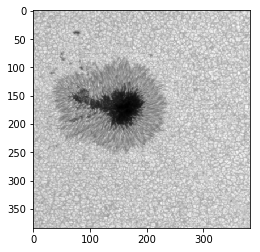

In [104]:
aa = maps[0,:,0:,0:]
lmb,nx,ny= aa.shape
#display full map
pl.figure(100)
pl.imshow(aa[0,0:,0:],cmap='gray')
pl.show()

In [105]:
#define intensity level here:
pnts = [0.2,0.4,0.6,0.8]
nlev = len(pnts)

shifts = np.zeros((nx,ny,len(pnts)), dtype=np.float64)

for k in tqdm(range(nlev)):
    print('calculation of level',k,'->',pnts[k])
    #intensity profile ranging from 0 (core) to 1 (continuum) [0-100%]
    for ip in range(nx):
        for jp in range(ny):
            si = aa[:,ip,jp]
            line = si - np.min(si)
            line = line/max(line)

            x = wav[10:55]
            y = line[10:55]
            n = len(x)                          #the number of data
            mean = sum(x*y)/n                   
            sigma = sum(y*(x-mean)**2)/n  
            popt,pcov = curve_fit(gauss,x,y,p0=[1,0.0,0.1])
            try:
                fb = interp1d(y[0:20],x[0:20])
                fr = interp1d(y[20:],x[20:])

                #pnts = [0.6]
                lb = fb(pnts[k])
                lr = fr(pnts[k])
                bcen = (lr+lb)/2
                shifts[ip,jp,k] = bcen
            except:
                pass



  0%|          | 0/4 [00:00<?, ?it/s]

calculation of level 0 -> 0.2




 25%|██▌       | 1/4 [01:57<05:53, 117.93s/it]

calculation of level 1 -> 0.4




 50%|█████     | 2/4 [03:50<03:52, 116.33s/it]

calculation of level 2 -> 0.6




 75%|███████▌  | 3/4 [05:50<01:57, 117.51s/it]

calculation of level 3 -> 0.8


/Users/rahul/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


100%|██████████| 4/4 [07:47<00:00, 117.41s/it]

In [106]:
shifts.shape,nlev

((384, 383, 4), 4)

(384, 383, 4)


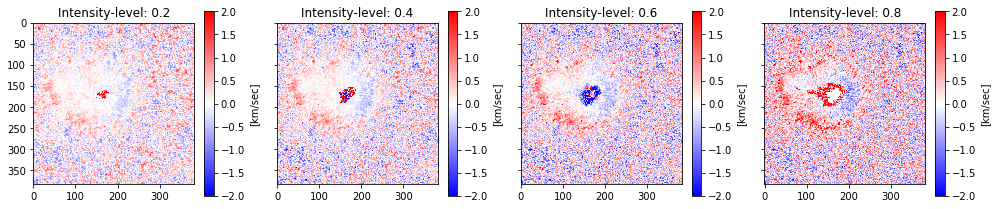

In [151]:
# See the maps
w0 = 6301.5
velo = (shifts[:,:,:]/w0)*clight
print(velo.shape)
fig, ax = pl.subplots(figsize=(14,3), nrows=1,ncols=4,sharey=True)
for i in range(4):
    ax[i].imshow(velo[:,:,i]/1000.,cmap='bwr',vmin=-2,vmax=2)
    ax[i].set_title('Intensity-level: '+str(pnts[i]))
    fig.colorbar(im,ax=ax[i],label='[km/sec]')
pl.tight_layout()
pl.show()

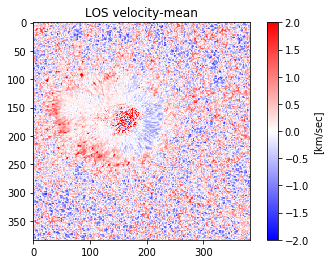

In [150]:
#calculate mean velocity

meanvel = np.zeros((nx,ny), dtype=np.float64)
for i in range(nx):
    for j in range(ny):
        meanvel[i,j] = np.mean(velo[i,j,:])

pl.imshow(meanvel/1000.,cmap='bwr',vmin=-2,vmax=2)
pl.title('LOS velocity-mean')
pl.colorbar(im,label='[km/sec]')